Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [1]:
import os, shutil, pathlib
from tensorflow import keras #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential, load_model #type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint #type: ignore
from keras.layers import Dense, Conv2D, RandomBrightness, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomZoom, RandomRotation, RandomContrast, Rescaling, GlobalMaxPooling2D#type: ignore
from keras.optimizers import Adam #type: ignore
from keras.regularizers import l2 #type: ignore
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Battery","Glass","Metal","Organic","Paper","Plastic"]

base_dir = pathlib.Path("ImagenesOrdenadas")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(224, 224),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")


Found 3252 files belonging to 6 classes.
Found 696 files belonging to 6 classes.
Found 702 files belonging to 6 classes.


2024-11-07 13:04:43.660351: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


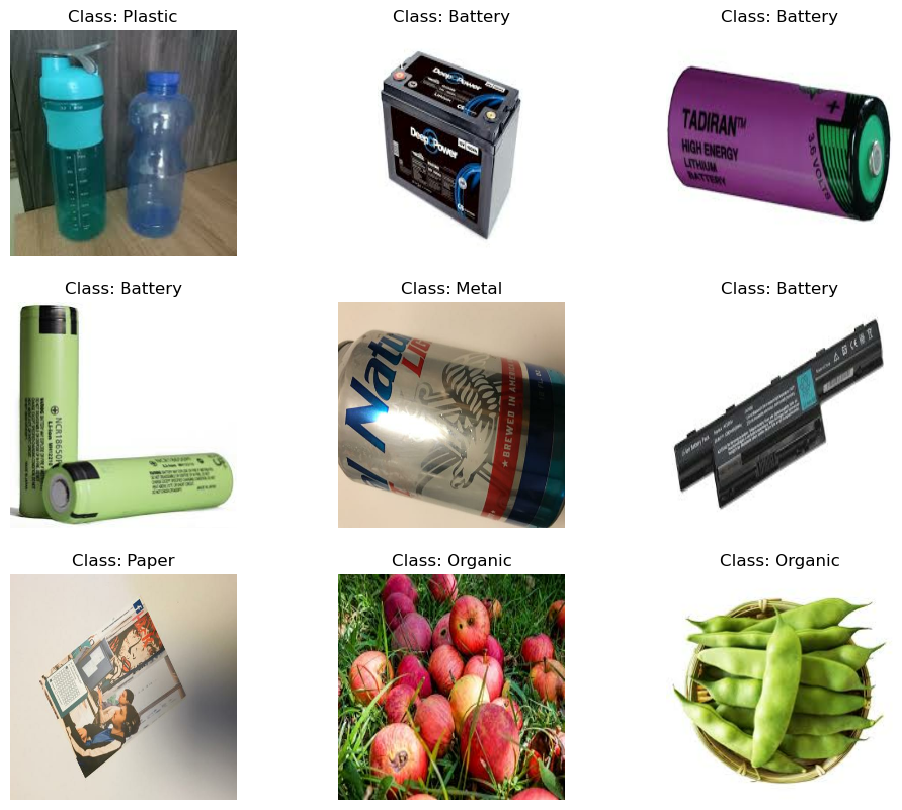

In [2]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

PRIMERO SE HACE LA RESIDUAL UNIT PARA EVITAR EL PROBLEMA DE LA DEGRADACIÓN que ocurre cuando un modelo profundo empeora su rendimiento debido a una pérdida de información en las capas.

In [3]:
class ResidualUnit(keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [4]:
def modelo_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()

    model.add(RandomFlip("horizontal_and_vertical", input_shape=input_shape))
    model.add(RandomRotation(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))
    
    prev_filters = 64
    for filters in [64] * 2 + [128] * 2 + [256] * 2:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    
    # Aplanamiento de las características
    model.add(GlobalAveragePooling2D())

    # Capa completamente conectada
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    return model

modelo = modelo_cnn(input_shape=(224, 224, 3), num_classes=6)
modelo.summary()


/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 55, 55, 64)     │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 55, 55, 64)     │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 28, 28, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 14, 14, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 14, 14, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,806 (1.61 MB)

 Trainable params: 416,262 (1.59 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [5]:
modelo.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:

early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=6,          
    restore_best_weights=True  
)

model_checkpoint = ModelCheckpoint(
    'best_model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min'
    )


# Entrenar el modelo
history = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopper, model_checkpoint]
)


Epoch 1/20


KeyboardInterrupt: 

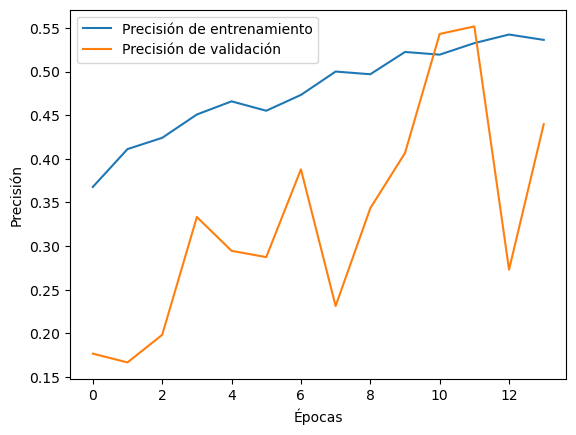

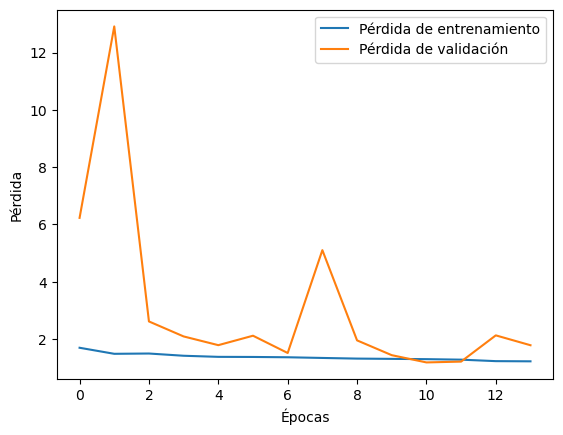

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
predictions = modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step


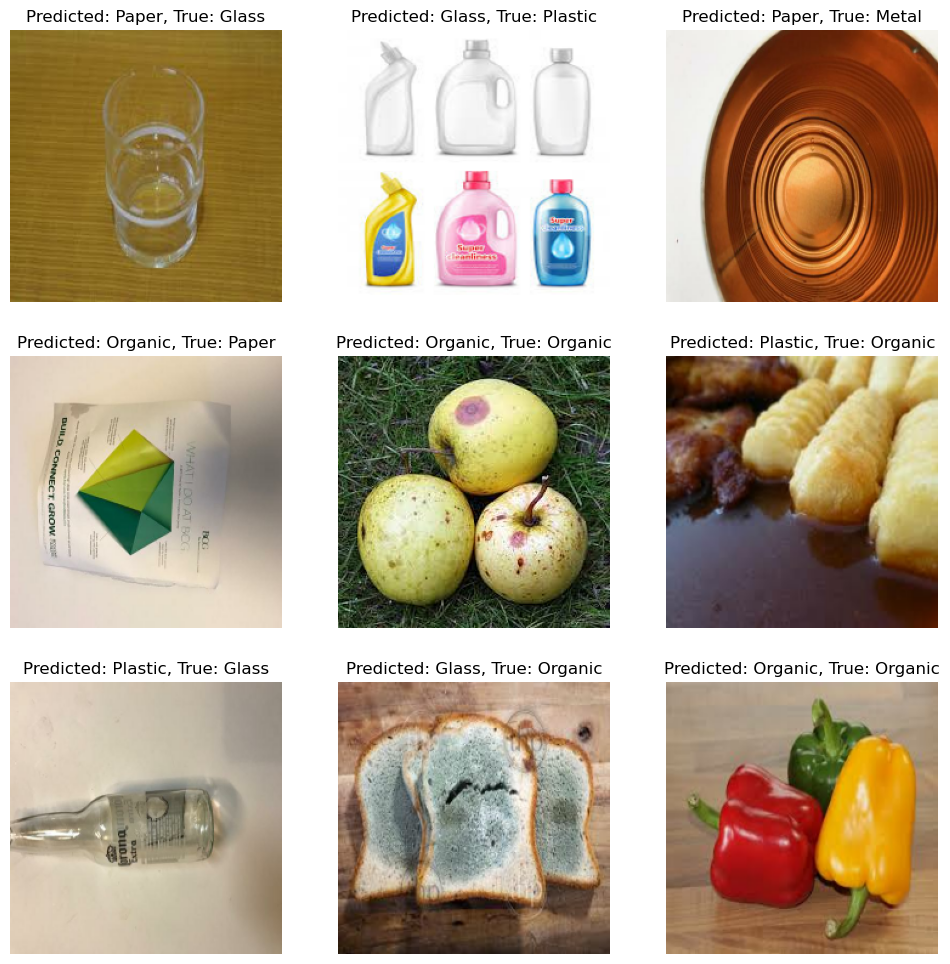

In [ ]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.5419 - loss: 1.2489
Test Loss: 1.2695999145507812, Test Accuracy: 0.5327635407447815


Ahora se harán algunas modificaciones al modelo para obtener mejores resultados

-Se le agregaron dos capas convolucionales mas (254,512)
-Ahora la capa Dense tiene 256 neuronas
-Adam con learning rate de 0.0001
-Dropout a 0.7
-Aumentar patience de early 
-Implementación de regularización l2 en capas de conv2d

Opté por mas capas de Rsidual en lugar de L2 regualirization porque esta última es mejor en modelos más simples, pero tareas como desvanecimiento de gradientes o de aprendizaje no las puede abordar eficazmente en redes profundas. Si se utilizaran solo L2, se estaría propiciando a que el modelo aprenda representaciones más superficiales.

In [ ]:
def modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()
    
    model.add(RandomFlip("horizontal_and_vertical",input_shape=input_shape))
    model.add(RandomContrast(0.3))
    model.add(RandomBrightness(0.3))
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(ResidualUnit(256, strides=2))
    model.add(ResidualUnit(256, strides=1))
    model.add(ResidualUnit(512, strides=2))
    model.add(ResidualUnit(512, strides=1))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

model_final = modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6)
model_final.summary()

/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 7, 7, 256)      │       204,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 7, 7, 256)      │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 4, 4, 512)      │       537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 4, 4, 512)      │       537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,940,678 (7.40 MB)

 Trainable params: 1,932,038 (7.37 MB)

 Non-trainable params: 8,640 (33.75 KB)

In [8]:
model_final.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopper,model_checkpoint]
)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.2341 - loss: 1.9202 - val_accuracy: 0.1667 - val_loss: 1.8164
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4173 - loss: 1.5018 - val_accuracy: 0.1667 - val_loss: 1.8122
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.4984 - loss: 1.3215 - val_accuracy: 0.1753 - val_loss: 1.7927
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5410 - loss: 1.2124 - val_accuracy: 0.2845 - val_loss: 1.7222
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5483 - loss: 1.1730 - val_accuracy: 0.4425 - val_loss: 1.4765
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6045 - loss: 1.1009 - val_accuracy: 0.6293 - val_loss: 1.1560
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6271 - loss: 1.0336 - val_accuracy: 0.6681 - val_loss: 0.9992
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6242 - loss: 1.0233 - 

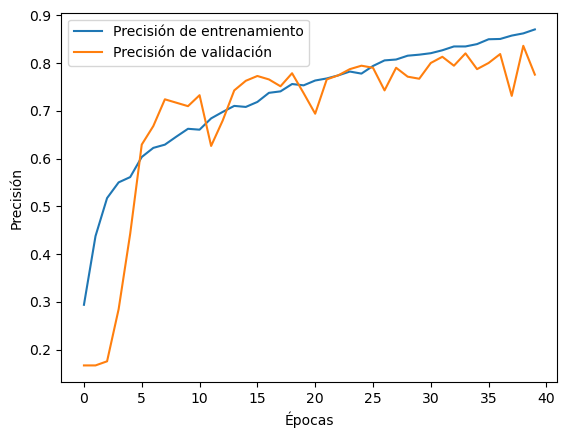

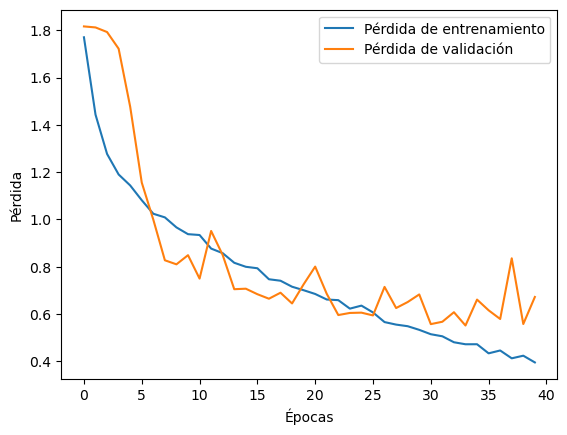

In [9]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [10]:
mejor_modelo = load_model('best_model_checkpoint.keras',custom_objects={'ResidualUnit': ResidualUnit})

predictions = mejor_modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/p

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step


2024-11-07 15:36:00.445723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


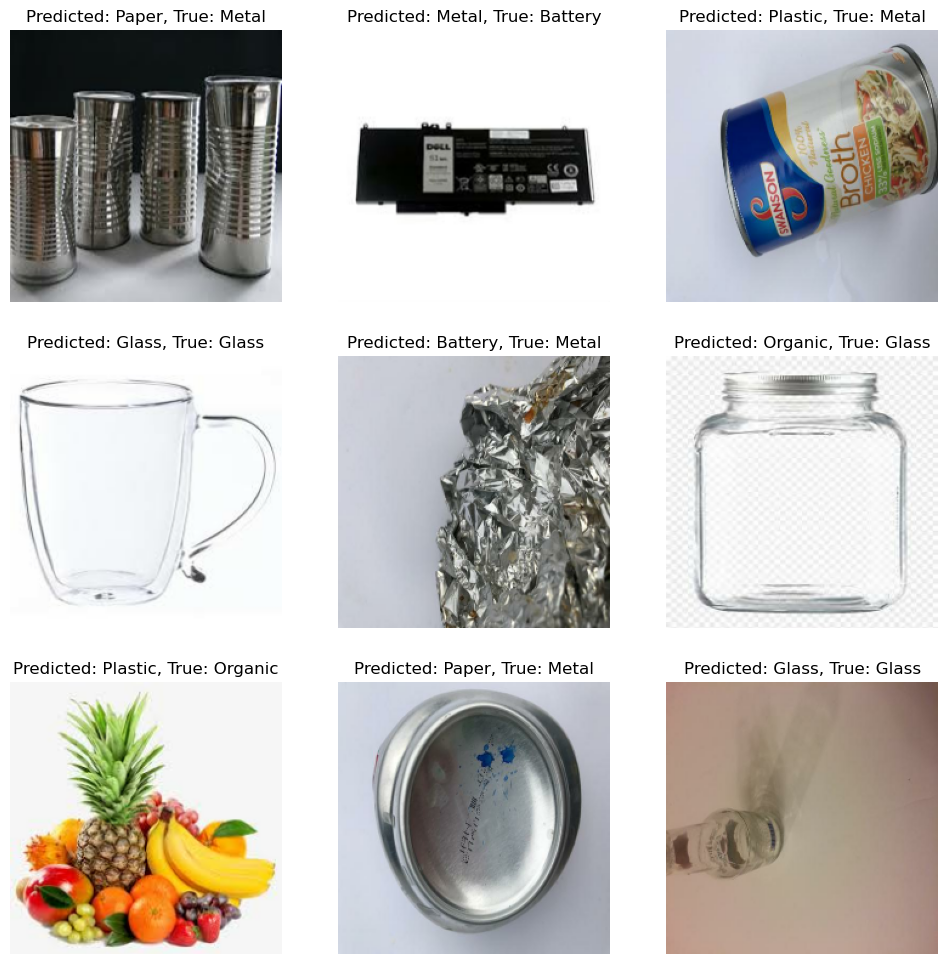

In [11]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [ ]:
test_loss, test_accuracy = mejor_modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.7882 - loss: 0.7366
Test Loss: 0.6876940131187439, Test Accuracy: 0.7849003076553345
